In [43]:
import torch
import torch.nn as nn
from cbam_swin import SwinUNETR_
from subpixel_swin_v2 import subpixel_SwinUNetrV2
from topTcbam_UNet import top_t_cbam_UNet
model_path = '/workspace/IITP/task_2D/dir_checkpoint_tumorResult/SubPixel_SwinUNetrV2_dataedited.pth'
device = "cuda:0"
roi_model = subpixel_SwinUNetrV2(img_size=(512,512),spatial_dims=2,in_channels=1,out_channels=1,depths=(2,2,2,2)).to(device=device)
if torch.cuda.device_count() > 1:
    roi_model = nn.DataParallel(roi_model,device_ids=[0,1,2]) 

roi_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [44]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from metric import *
from torch.utils.data import DataLoader

In [65]:
import numpy as np
from PIL import Image
import torch as torch
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import cv2
from einops import rearrange
from custom_transforms import *
import pydicom as dcm
from pydicom.pixel_data_handlers.util import apply_voi_lut


class tumor_Dataset(Dataset):
    def __init__(self,path, train=True):
        self.path = path
        self.train = train
        self.train_path_list = []
        self.train_list = []

        self.label_path_list = []
        self.label_list = []

        self.train_path = path + "/input"
        self.label_path = path + "/target"

        
        for file in os.listdir(self.train_path):
            self.train_path_list.append(os.path.join(self.train_path,file))
        self.train_path_list.sort()
                
        for file in os.listdir(self.label_path):
            self.label_path_list.append(os.path.join(self.label_path,file))           
        self.label_path_list.sort()


    def __len__(self):
        return len(self.label_path_list)
    
    def get_label(self,image):
     if np.any(image == 1):
        return 1
     else:
        return 0

    def __getitem__(self,idx):
        if self.train:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize((512,512)),
                                                customRandomRotate(degrees=180,SEED=idx),
                                                customRandomHorizontalFlip(p=0.5,SEED=idx)
                                                #customRandomResizedCrop(SEED=idx,size=(256,256))
                                                ])
            
            
        image_path = self.train_path_list[idx]
        print("image_path : ", image_path)

        slice = dcm.read_file(image_path)
        image = slice.pixel_array
        image = apply_voi_lut(image, slice)
        epsilon = 1e-10
        min_val = np.min(image)
        max_val = np.max(image)
        image = (image - min_val) / (max_val - min_val+epsilon)
        
        image = Image.fromarray(image)

        label_path = self.label_path_list[idx]
        print("label_path : ", label_path)
        label = np.array(Image.open(label_path).convert("L"))
        label = Image.fromarray(label)


        input_image = self.transform(image)
        target_image = self.transform(label)


        thresh = np.zeros_like(target_image)
        thresh[target_image > 0.5] = 1

        class_label = self.get_label(thresh)

        return input_image, thresh, class_label

In [66]:
dataset = tumor_Dataset("/mount_folder/sampling/test/balance")
test_loader = DataLoader(dataset,batch_size=1,shuffle=True)

In [ ]:
NOP = {}
for idx, (img,label,_) in enumerate(test_loader):
    nop = torch.sum(label)
    NOP[f"Image_{idx}"] = nop


image_path :  /mount_folder/sampling/test/balance/input/8659957_127.dcm
label_path :  /mount_folder/sampling/test/balance/target/8659957_127.png


/tmp/ipykernel_1807808/638301769.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha_red = plt.cm.get_cmap('Reds')
/tmp/ipykernel_1807808/638301769.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha_red = plt.cm.get_cmap('Reds')


Number of Pixels:  734.0
DSC : 0.8759
Recall : 0.9278


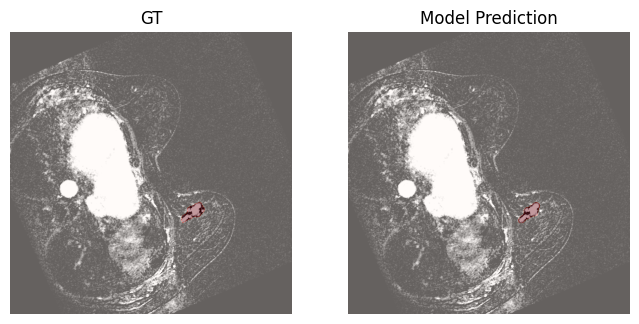

: 

In [85]:
import random
num = random.randint(0,4000)
img,label,_ = dataset.__getitem__(idx=num)


plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(),cmap='Greys_r')
alpha_red = plt.cm.get_cmap('Reds')
plt.imshow(label.squeeze(),alpha=0.4,cmap=alpha_red,clim=[0.0, 1.0],)
plt.title("GT")
plt.axis('off')


net_path = '/workspace/IITP/task_2D/dir_checkpoint_tumorResult/SubPixel_SwinUNetrV2_dataedited.pth'
net = subpixel_SwinUNetrV2(img_size=(512,512),spatial_dims=2,in_channels=1,out_channels=1,depths=(2,2,2,2)).to(device=device)
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net,device_ids=[0,1,2,3]) 
net.load_state_dict(torch.load(net_path))

output = torch.sigmoid(net(img.unsqueeze(0)))
thresh = torch.zeros_like(output)
thresh[output>0.5] = 1.0

np_thresh = thresh.cpu().detach().numpy()

plt.subplot(1,2,2)
plt.imshow(img.squeeze(),cmap='Greys_r')
alpha_red = plt.cm.get_cmap('Reds')
plt.imshow(np_thresh.squeeze(),alpha=0.4,cmap=alpha_red,clim=[0.0, 1.0])
plt.title("Model Prediction")
plt.axis('off')
nop = int(NOP[f"Image_{id}"])
#plt.savefig(f"/mount_folder/images/{nop}.png")

print("Number of Pixels: ",np.sum(np_thresh))

print("DSC : {:.4f}".format(dice_score(thresh.cuda(),torch.from_numpy(label).cuda()).item()))
print("Recall : {:.4f}".format(recall_score(thresh.cuda(),torch.from_numpy(label).cuda()).item()))


In [ ]:
sample = 

In [104]:
test_dataset.__len__()

756